<a href="https://colab.research.google.com/github/KorwinBieniek/kaggle_projects/blob/main/notebooks/dogs_cats_classification/stanford_dogs_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2020/04/28<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


## Setup


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds


In [59]:
def load_dataset():
    """
    Load stanford_dogs tensorflow dataset.
    :return:
    ds_train (tf.data.DataSet) The requested training dataset.
    ds_test (tf.data.DataSet) The requested test dataset.
    ds_info (tfds.core.DatasetInfo) The requested dataset info.
    """
    (ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                             split=['train', 'test'],
                                             shuffle_files=True,
                                             as_supervised=False,
                                             with_info=True,
                                             data_dir='data/tfds')
    return ds_train, ds_test, ds_info


def preprocess(data, image_size, num_labels, cast=True, resize=True, normalize=True, one_hot=True):
    """
    Process an image.
    :param data: Tensorflow datset containing an image and label.
    :param image_size: Size of the image. Images may be resized to this size. E.g. (224, 224)
    :param num_labels: Number of labels for prediction.
    :param cast: Flag for casting to float32. True or False.
    :param resize: Flag for resizing the image. True or False.
    :param normalize: Flag for normalizing the image pixel values from 0-1. True or False.
    :param one_hot: Flag for one hot encoding the labels. True or False.
    :return: Processed image and encoded label.
    """
    # processed_image = tf.keras.applications.resnet.preprocess_input(data['image'])
    processed_image = data['image']
    label = data['label']
    if cast:
        processed_image = tf.cast(processed_image, tf.float32)
    if resize:
        processed_image = tf.image.resize(processed_image, image_size, method='nearest')
    if normalize:
        processed_image = processed_image / 255.
    if one_hot:
        label = tf.one_hot(label, num_labels)
    return processed_image, label


def prepare(dataset, image_shape, num_classes, batch_size=None):
    """
    Prepare an input pipeline for training a dataset.
    :param dataset: The dataset containing training data.
    :param image_shape: A common shape of the input image. Images with different sizes will be resized. E.g. (80, 80, 3)
    :param num_classes: Number of prediction classes.
    :param batch_size: Batch size for training.
    :return: Prepared dataset.
    """
    dataset = dataset.map(lambda x: preprocess(x, image_shape[0:-1], num_classes),
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    if batch_size is not None:
        dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


input_shape = (224, 224, 3)
num_breeds = 120

train_ds, test_ds, ds_info = load_dataset()
train_ds = prepare(train_ds, input_shape, num_breeds, batch_size=32)
test_ds = prepare(test_ds, input_shape, num_breeds,  batch_size=32)

### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".


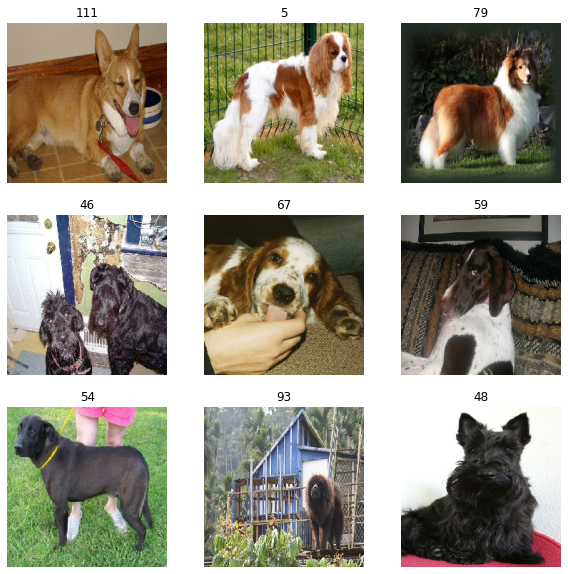

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(int(labels.numpy()[i].argmax()))
        plt.axis("off")


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [73]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


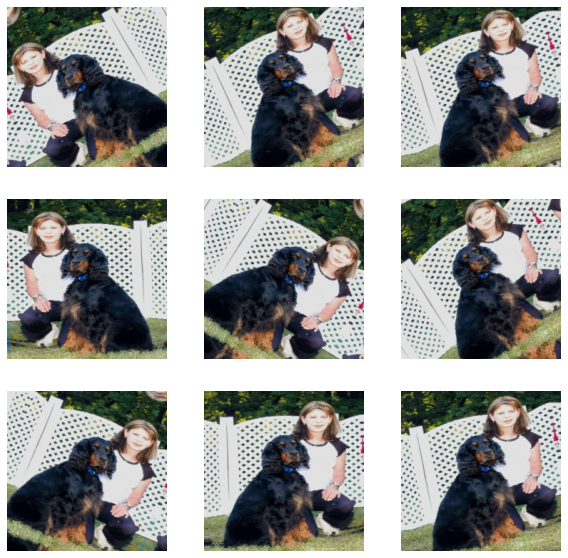

In [74]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0])
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [ ]:
# train_ds = train_ds.prefetch(buffer_size=32)
# val_ds = val_ds.prefetch(buffer_size=32)


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


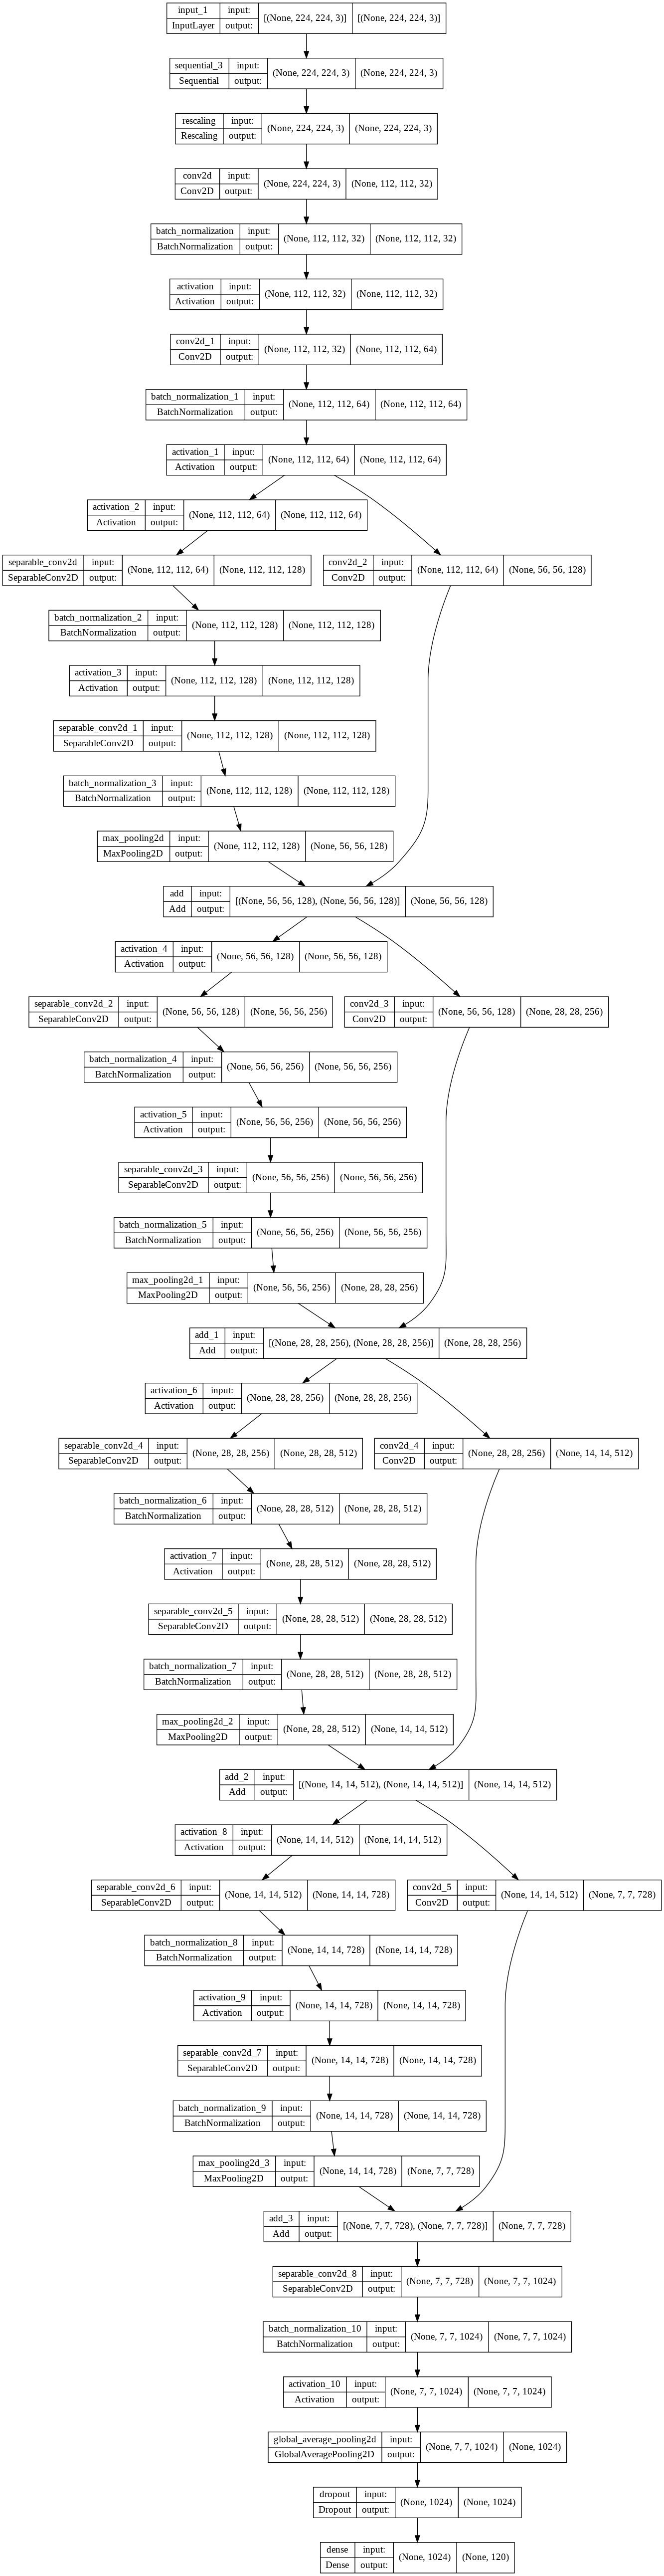

In [75]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=(224, 224, 3), num_classes=120)
keras.utils.plot_model(model, show_shapes=True)


## Train the model


In [77]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=test_ds
)

Epoch 1/5
 68/375 [====>.........................] - ETA: 3:33 - loss: 0.0891 - accuracy: 0.0092

KeyboardInterrupt: ignored

We get to ~96% validation accuracy after training for 50 epochs on the full dataset.


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


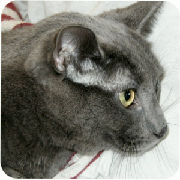

This image is 25.64 percent cat and 74.36 percent dog.


In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
display(img)
predictions = model.predict(img_array)
score = predictions.item()
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)


In [81]:
for l in model.layers]:
    l.trainable = False
    
for l in model.layers[-6:]:
    l.trainable = True